# Show the angle between the electron and the hadron in $(e,e'\pi)$ events

last edit Feb-12, 2022

## Imports and definitions

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/Software/mySoftware/Python/'); 
from my_tools               import *; 
from plot_tools             import *;
from my_data_analysis_tools import *;
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
r2d = 180./np.pi

In [2]:
main_data_path     = '/Users/erezcohen/Desktop/data/BAND/'
e_e_pi_data_path   = main_data_path + 'SIDIS_skimming/'
e_e_pi_n_data_path = main_data_path + 'merged_SIDIS_and_BAND_skimming/'

In [3]:
pi_charge_names  = ['piplus'   ,'piminus'  ]
pi_labels        = ['\pi^{+}'  ,'\pi^{-}'  ]
pi_colors        = ['royalblue','salmon'   ]

## Selection cuts not previously imposed

In [4]:
# for pi_charge_name in pi_charge_names:
#     # large momentum neutrons ( Pn > 275 MeV/c)
#     e_e_pi_n[pi_charge_name] = e_e_pi_n[pi_charge_name][e_e_pi_n[pi_charge_name]['n_P']>0.275]
    
#     print('retained',len(e_e_pi_n[pi_charge_name]),'(e,e',pi_charge_name,'n), events')        

## Auxiliary functions

In [5]:
fontsize = 18

In [6]:
def plot_step_hist( df, var='xB',
                   bins=np.linspace(0,1,10), label="$(e,e')$"):
    h,edges = np.histogram( df[var], bins=x_bins)
    h_err = np.sqrt(h)
    x     = (edges[1:] + edges[:-1])/2
    x_err = (edges[1:] - edges[:-1])/2
    plt.step ( x, h, color=pi_color, where='mid', label=label ) 
    plt.errorbar ( x, h, h_err, color=pi_color, marker='o', linestyle='None',label=None, capsize=2 )
    return x,h,x_err

In [7]:
def get_err_up_dw(x, xerr,lim_dw = 0,lim_up = 10):
    errup=xerr
    errdw=xerr
    
    for i in range(len(x)):
        if (x[i]+errup[i]) > lim_up:
            errup[i] = lim_up-x[i]
        
        if lim_dw > (x[i]-errdw[i]):
            errdw[i] = x[i]-lim_dw
        

    return errup,errdw

In [8]:
def compute_ratio_pips_to_pims(df_dict, var='xB', bins=np.linspace(0,1,10), z_min=0, z_max=1, 
                               theta_min=0, theta_max=np.pi, 
                               Mx_min=0, Mx_max=100,  
                               is_eepi=True):
    # z_min,z_max are z limits on the pion outgoing momentum
    df_pips = df_dict['piplus']
    df_pims = df_dict['piminus']
    # cut on z
    df_pips = df_pips[ (z_min<df_pips.Zpi) & (df_pips.Zpi<z_max) 
                      & (theta_min<df_pips.pi_Theta*r2d) & (df_pips.pi_Theta*r2d<theta_max) ]
    
    df_pims = df_pims[ (z_min     < df_pims.Zpi)          & (df_pims.Zpi          < z_max) 
                      & (theta_min< df_pims.pi_Theta*r2d) & (df_pims.pi_Theta*r2d < theta_max)]

    # and cut on Mx if its (e,e'pi)
    if is_eepi:#{
        df_pips = df_pips[ (Mx_min < df_pips.M_X) & (df_pips.M_X < Mx_max)]    
        df_pims = df_pims[ (Mx_min < df_pims.M_X) & (df_pims.M_X < Mx_max)]
    #}
    
    pips = df_pips[var]
    pims = df_pims[var]
    R_pips_to_pims, R_pips_to_pims_err = [],[]
    for x_min,x_max in zip(bins[:-1],bins[1:]):
        
        pips_in_bin  = pips[ (x_min < pips) & (pips < x_max) ]
        Npips_in_bin = len(pips_in_bin)
        pims_in_bin  = pims[ (x_min < pims) & (pims < x_max) ]
        Npims_in_bin = len(pims_in_bin)    

        R            = Npips_in_bin/np.max([Npims_in_bin,1])
        R_err        = R * np.sqrt( 1./np.max([1,Npips_in_bin]) + 1./np.max([1,Npims_in_bin]) )

        R_pips_to_pims    .append(R)
        R_pips_to_pims_err.append(R_err)
        
    R_pips_to_pims_errup,R_pips_to_pims_errdw = get_err_up_dw(R_pips_to_pims, R_pips_to_pims_err)
    
    return np.array(R_pips_to_pims),np.array(R_pips_to_pims_errup),np.array(R_pips_to_pims_errdw)

In [9]:
def compute_ratio_assymetry(df_dict, var='xB', bins=np.linspace(0,1,10), z_min=0, z_max=1,                                
                            theta_min=0, theta_max=np.pi,                             
                            Mx_min=0, Mx_max=100,
                            is_eepi=True):
    # z_min,z_max are z limits on the pion outgoing momentum
    df_pips = df_dict['piplus']
    df_pims = df_dict['piminus']
    # cut on z
    df_pips = df_pips[ (z_min<df_pips.Zpi) & (df_pips.Zpi<z_max) 
                      & (theta_min<df_pips.pi_Theta*r2d) & (df_pips.pi_Theta*r2d<theta_max) ]
    
    df_pims = df_pims[ (z_min     < df_pims.Zpi)          & (df_pims.Zpi          < z_max) 
                      & (theta_min< df_pims.pi_Theta*r2d) & (df_pims.pi_Theta*r2d < theta_max)]

    # and cut on Mx if its (e,e'pi)
    if is_eepi:#{
        df_pips = df_pips[ (Mx_min < df_pips.M_X) & (df_pips.M_X < Mx_max)]    
        df_pims = df_pims[ (Mx_min < df_pims.M_X) & (df_pims.M_X < Mx_max)]
    #}
    

    pips = df_pips[var]
    pims = df_pims[var]
    Rassymetry, Rassymetry_err = [],[]
    for x_min,x_max in zip(bins[:-1],bins[1:]):
        
        pips_in_bin  = pips[ (x_min < pips) & (pips < x_max) ]
        Npips_in_bin = len(pips_in_bin)
        pims_in_bin  = pims[ (x_min < pims) & (pims < x_max) ]
        Npims_in_bin = len(pims_in_bin)    

        nom          = (Npips_in_bin + Npims_in_bin)
        den          = np.max([Npips_in_bin - Npims_in_bin,1])
        R            = nom/den
        R_err        = np.abs(1/den) * np.sqrt(  Npips_in_bin*np.square(1 - Npips_in_bin/den)
                                               + Npims_in_bin*np.square(1 + Npims_in_bin/den) )

        Rassymetry    .append(R)
        Rassymetry_err.append(R_err)
        
    Rassymetry_errup,Rassymetry_errdw = get_err_up_dw(Rassymetry, Rassymetry_err)
    
    return np.array(Rassymetry),np.array(Rassymetry_errup),np.array(Rassymetry_errdw)

# Accumulated data from 101 runs of 10.2 GeV

## load data

In [10]:
runs_filename = "/Users/erezcohen/Desktop/Software/CLAS12/BAND/SIDIS_at_BAND/macros/runlists/good_runs_10-2-final.txt"

# Using readlines()
runs_file     = open(runs_filename, 'r')
run_fileLines = runs_file.readlines()
runs = []
for line in run_fileLines[0:4]:#{
    run = int(line.strip())
    runs.append(run)
runs = np.array(runs)
runs

array([6420, 6421, 6422, 6426])

In [11]:
fdebug   = 1
e_e_pi   = dict()
e_e_pi_n = dict()
for runnum,runIdx in zip(runs,range(len(runs))):
    for pi_charge_name in pi_charge_names:
        eepi   = pd.read_csv(e_e_pi_data_path 
                                           +'skimmed_SIDIS_inc_00%d_e_%s_selected_eepi_kinematics.csv'%(runnum,pi_charge_name))
        eepin = pd.read_csv(e_e_pi_n_data_path 
                                           +'skimmed_SIDIS_and_BAND_inc_00%d_e_%s_n.csv'%(runnum,pi_charge_name))        

        if fdebug>1: print('loaded',len(eepi),'(e,e',pi_charge_name,                  
                           ') events and ',
                           len(eepin),'(e,e',pi_charge_name,'n), events')    
    
        # large momentum neutrons ( Pn > 275 MeV/c)
        eepin = eepin[eepin['n_P']>0.275]
        if fdebug>2: print('retained',len(eepin),'(e,e',pi_charge_name,'n), events')            
        
        if runIdx==0:             
            e_e_pi[pi_charge_name]   = eepi
            e_e_pi_n[pi_charge_name] = eepin
        else:
            e_e_pi[pi_charge_name]   = pd.concat([e_e_pi[pi_charge_name],  eepi ])
            e_e_pi_n[pi_charge_name] = pd.concat([e_e_pi_n[pi_charge_name],eepin])
    print('loaded file %d/%d files'%(runIdx,len(runs)))
    
print('done.')

loaded file 0/4 files
loaded file 1/4 files
loaded file 2/4 files
loaded file 3/4 files


# Compute and plot the angle between the hadron and the electron

In [21]:
Theta_e_pi = dict()
for pi_charge_name in pi_charge_names:
    
    P_e = np.array(e_e_pi[pi_charge_name].e_P)
    Theta_e = np.array(e_e_pi[pi_charge_name].e_Theta)
    Phi_e = np.array(e_e_pi[pi_charge_name].e_Phi)

    Px_e = P_e * np.sin(Theta_e) * np.cos(Phi_e)
    Py_e = P_e * np.sin(Theta_e) * np.sin(Phi_e)
    Pz_e = P_e * np.cos(Theta_e) 
    
    P_pi = np.array(e_e_pi[pi_charge_name].pi_P)
    Theta_pi = np.array(e_e_pi[pi_charge_name].pi_Theta)
    Phi_pi = np.array(e_e_pi[pi_charge_name].pi_Phi)

    Px_pi = P_pi * np.sin(Theta_pi) * np.cos(Phi_pi)
    Py_pi = P_pi * np.sin(Theta_pi) * np.sin(Phi_pi)
    Pz_pi = P_pi * np.cos(Theta_pi) 

    cos_Theta_e_pi = (Px_e*Px_pi + Py_e*Py_pi + Pz_e*Pz_pi)/(P_e*P_pi)
    Theta_e_pi[pi_charge_name] = np.arccos(cos_Theta_e_pi)
    
print('done computation')

done computation


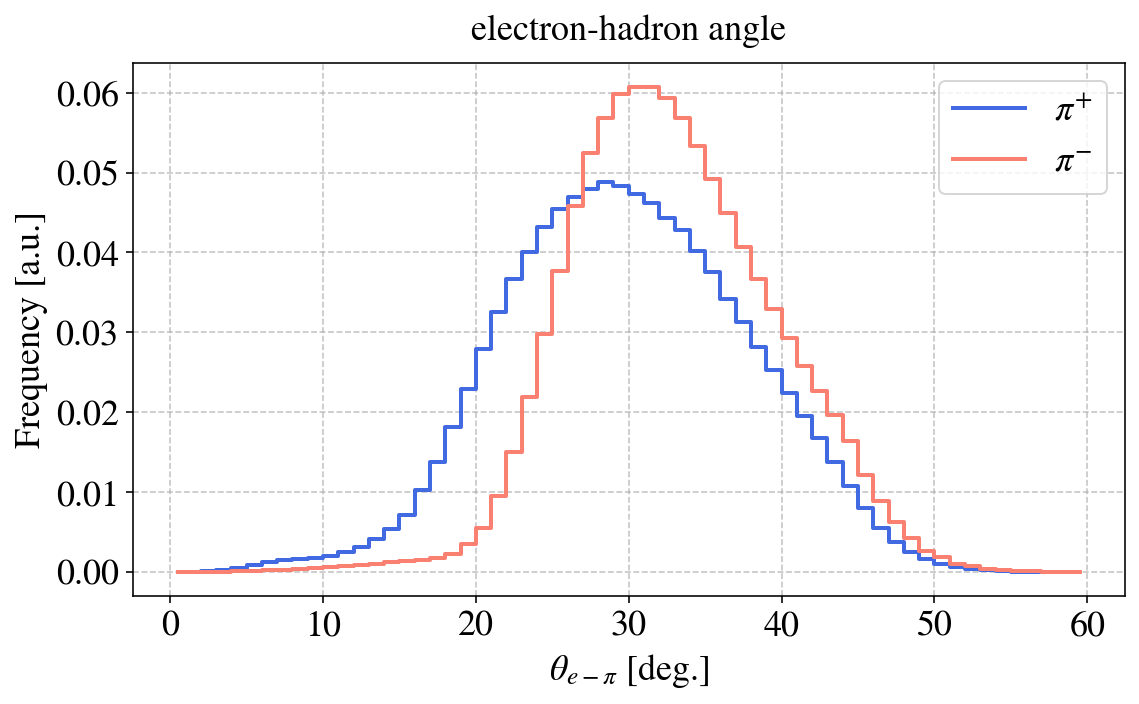

In [36]:
bins = np.linspace(0,60,61)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
for pi_charge_name,pi_label,pi_color in zip(pi_charge_names,pi_labels,pi_colors):
    theta = Theta_e_pi[pi_charge_name] 
    # plot_step_hist( theta*r2d, bins=bins , label=pi_label , color=pi_color)
    h,edges = np.histogram( theta*r2d, bins=bins, density=True )
    x = (edges[1:]+edges[:-1])/2
    plt.step( x, h , where='mid'  , color=pi_color , label='$'+pi_label+'$', linewidth=2)
    
set_axes(ax,"$\\theta_{e-\pi}$ [deg.]" ,
         "Frequency [a.u.]" ,
         title='electron-hadron angle',
     do_add_grid=True, do_add_legend=True, fontsize=fontsize);
# #}
plt.tight_layout()